# Notebook 2: Position Interneurons

### General Overview

Two position integrators (INs) are integrated in each joint, with the function of integrating all spikes originating from a given hair field into a position-dependent spike train. These spike trains are able to encode the varying joint angles over time through their spike rate.

### Cell-by-Cell Description

#### Importing Modules and Creating Folders

This cell serves to import general functions, modules, and dictionaries from the 'general' module. Additionally, it imports the LIF class, which is integral to subsequent analyses. The LIF class is a simplified LIF neuron, see 'classes.py' for more information.


In [9]:
from general import *
from classes import LIF

create_folder_if_not_exists('images')
create_folder_if_not_exists('images/position_neuron')

Folder 'images' already exists.
Folder 'images/position_neuron' already exists.


### The LIF Model

The Leaky Integrate-and-Fire (LIF) model establishes a linear relationship between the input current or spikes and the resulting output spike rate. Unlike the AdEx model, which includes adaptation mechanisms, the LIF model solely integrates its input and decays over time without any adaptation. The LIF model dynamics are implemented using the `LIF` class from the 'classes.py' file. 

First, we define the model parameters, create an instance and initialize the model.

In [10]:
# Define parameters for the position neuron using the LIF model
position_parameters = {
    'tau': 120e-3,                          # Membrane time constant (s)
    'V_T': -50e-3,                          # threshold voltage (V)
    'V_R': -70e-3,                          # Reset voltage after spike (V)
    'dt': constants['dt'],                  # Simulation time step (s)
    'n': 2 * constants['N_ANGLES'],         # Number of neurons (2 for each joint)
    'w': 25e-3,                             # Synaptic weight, 1E-3 for manuscript 1, 25E-3 for manuscript 2
    'N_input': parameters['N_HAIRS'] // 2,  # Number of input neurons
    'n_sims': 1,                            # Number of simulations
    'multiple_synapses': True               # Multiple synapses flag
}

# Initialize the position neuron with the defined parameters and the neuron state
position_neuron = LIF(position_parameters)
position_neuron.initialize_state()

The `run_position()` function simulates the position neuron response to sensory spikes. It reshapes the sensory spike data and processes it through the position neuron (LIF) model, iterating over each time step and simulation, and returns the resulting position neuron spikes. It does this for 78 'no step' trials and 21 'step' trials. 

In [11]:
def run_position(spike_sensory, n_simulations, n_steps, t_total):
    
    # Initialize output array for position neuron spikes
    spike_position = np.empty((n_steps, position_parameters['n'], n_simulations), dtype=np.uint8)
    
    # Loop through each simulation and timestep
    for k in tqdm(range(n_simulations)):
        for i in range(n_steps):
            
            # Reshape sensory spikes for input to the position neuron: shape (simulations, hairs)
            reshaped_spikes = np.reshape(spike_sensory[i, :, k], (position_parameters['n'], parameters['N_HAIRS']))
            
            # Forward pass through the position neuron, only considering half of the hairs
            _, spike_position[i, :, k] = position_neuron.forward(reshaped_spikes[:, parameters['N_HAIRS'] // 2:])
    
    return spike_position

In [12]:
# Load joint angles and sensory spike data from files
with open('temp_data/joint_angles.npy', 'rb') as file:
    joint_angles = np.load(file)

with open('temp_data/spike_sensory', 'rb') as file:
    spike_sensory = np.load(file)

with open('temp_data/spike_sensory_step', 'rb') as file:
    spike_sensory_step = np.load(file)

# Run position neuron simulation for regular and step data
spike_position = run_position(spike_sensory, min(parameters['N_SIMULATIONS'], 78), constants['N_STEPS'], constants['T_TOTAL'])
spike_position_step = run_position(spike_sensory_step, min(parameters['N_SIMULATIONS'], 21), constants['N_STEPS_STEP'], constants['T_TOTAL_STEP'])

# Save the position spike data if required
if parameters['save_data']:
    with open('temp_data/spike_position', 'wb') as file:
        np.save(file, spike_position)
        
    with open('temp_data/spike_position_step', 'wb') as file:
        np.save(file, spike_position_step)

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

#### Testing & Visualization: Position IN Response to Joint Angle Stimulus

This figure shows the spike rate response of pos+ and pos- INs to a joint angle stimulus. The pos+ IN fires when the joint angle exceeds the resting angle, while the pos- IN fires when the joint angle is below the resting angle.

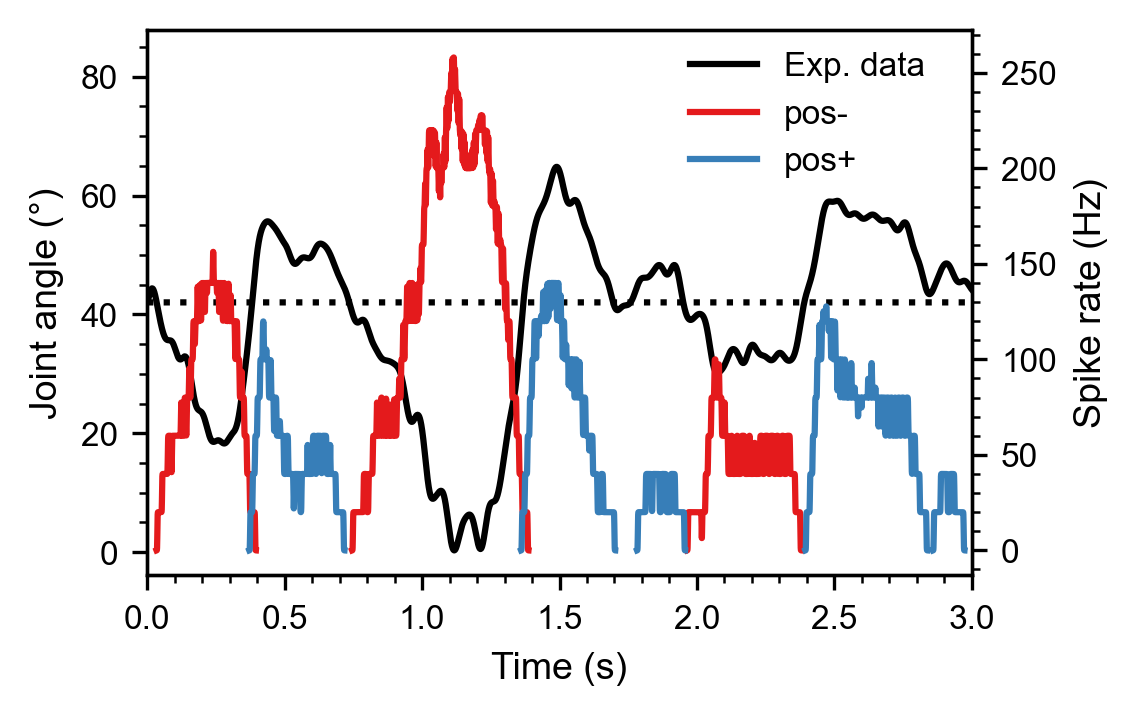

In [13]:
# Create a figure with two y-axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Define handles for legend labels
handles = ['pos-', 'pos+']

# Define time array
time = np.linspace(0, constants['T_TOTAL'], num=constants['N_STEPS'])

# Plot firing rates of pos- and pos+ neurons
for i in range(2):
    firing_rate = get_firing_rate_convolve(spike_position[:, i, 0], constants['dt'], 0.05)
    ax2.plot(time, firing_rate, color=custom_colors[i], label=handles[i])

# Plot experimental joint angle data and resting angle
ax1.plot(time, joint_angles[:, 0, 0], color='black', label='Exp. data')
ax1.plot(time, np.full(len(time), np.max(joint_angles[:, 0, 0]) / 2 + np.min(joint_angles[:, 0, 0]) / 2), 
         linestyle='dotted', color='black')

# Set ax1 parameters
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Joint angle (°)")
ax1.minorticks_on()
ax1.set_xlim([0, 3])

# Set ax2 parameters
ax2.set_ylabel("Spike rate (Hz)")
ax2.minorticks_on()
ax2.set_xlim([0, 3])

# Add a legend to the figure
fig.legend(loc='lower right', frameon=False, bbox_to_anchor=[0.85, 0.72])

# Adjust layout and save the figure
fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/position_neuron/P1_fig4c.png')

This figure plots the combined spike rate response of the model alongside the ground truth (joint angle).

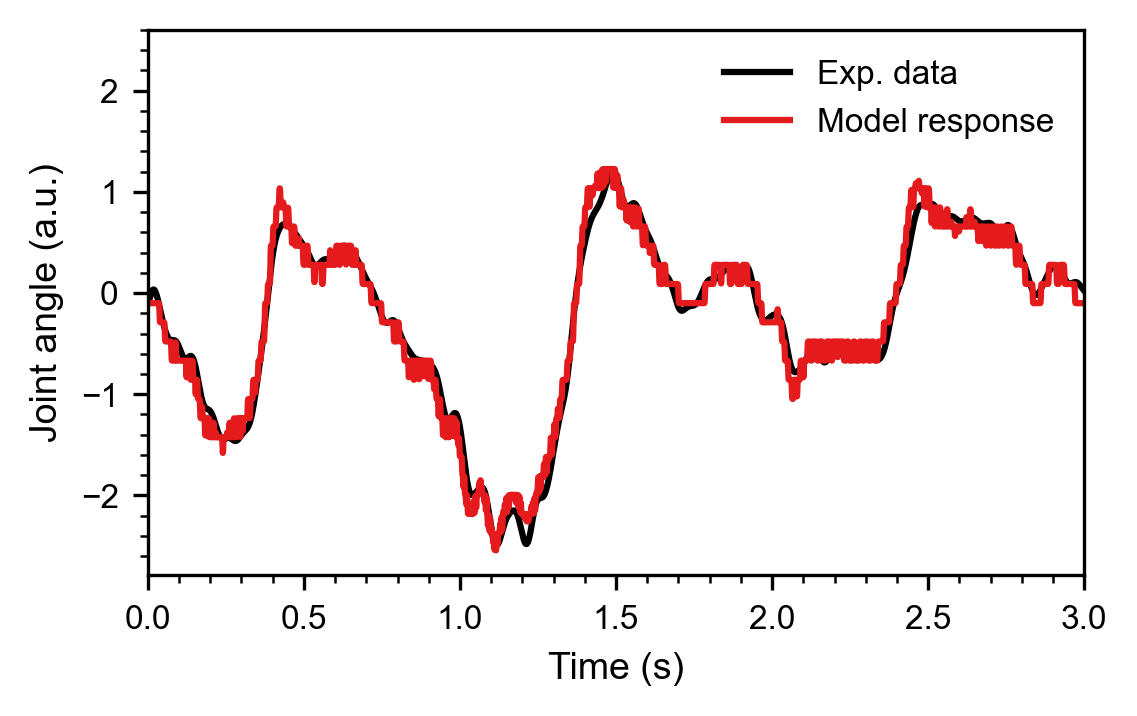

In [14]:
# Calculate firing rates
firing_rate_down = get_firing_rate_convolve(spike_position[:, 0, 0], constants['dt'], 0.05, nan_bool=False)
firing_rate_up = get_firing_rate_convolve(spike_position[:, 1, 0], constants['dt'], 0.05, nan_bool=False)

# Combine and z-normalize firing rates
combined_firing_rate = firing_rate_up - firing_rate_down
combined_firing_rate_norm = zscore.zscore(combined_firing_rate)

# Z-Normalize joint angles
joint_angle_norm = zscore.zscore(joint_angles[:, 0, 0])

# Create plot
fig, ax = plt.subplots()

# Plot experimental data and model response
ax.plot(time, joint_angle_norm, color='black', label='Exp. data')
ax.plot(time, combined_firing_rate_norm, color=custom_colors[0], label='Model response')

# Set plot parameters
ax.set_xlim([0, 3])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Joint angle (a.u.)")
ax.minorticks_on()
ax.legend(frameon=False)

# Adjust layout and save figure
fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/position_neuron/P1_fig4d.png')

#### Optimization and performance

We calculate the Mean Squared Error (MSE) between the z-normalized joint angles and the z-normalized combined pos+ and pos- spike rates. The MSE is averaged over each timestep, joint, and trial. Optimization occurs only if the `run_optimization` parameter is set to True. The results are plotted in a heatmap

In [15]:
if parameters['run_optimization']:
    # Define parameters, initialize arrays
    N_GRID = 8
    N_ANGLES = 18
    weight_list = np.linspace(1e-3, 8e-3, num=N_GRID)
    tau_list = np.linspace(40e-3, 180e-3, num=N_GRID)
    MSE = np.empty((N_ANGLES, parameters['N_SIMULATIONS'], N_GRID, N_GRID))
    
    # loop over different weights and taus 
    for l, m in tqdm(np.ndindex(N_GRID, N_GRID), desc=f'Total iterations: {N_GRID * N_GRID}'):
        # Update position parameters, different for each iteration
        position_parameters['w'] = weight_list[l]
        position_parameters['tau'] = tau_list[m]
        
        # Initialize position neuron model using these parameters
        position_neuron = LIF(position_parameters)
        position_neuron.initialize_state()
        
        # Loop over simulations and simulation steps
        for k in range(parameters['N_SIMULATIONS']):
            for i in range(constants['N_STEPS']):
                # Reshape spikes for the current simulation step
                reshaped_spikes = np.reshape(spike_sensory[i, :, k], (position_parameters['n'], parameters['N_HAIRS']))
                
                # Forward pass through the position neuron model
                _, spike_position[i, :, k] = position_neuron.forward(reshaped_spikes[:, parameters['N_HAIRS'] // 2:])
            
            # Loop over all 18 joint angles
            for i in range(N_ANGLES):
                # Compute firing rates
                firing_rate_down = get_firing_rate_convolve(spike_position[:, 0 + 2 * i, k], constants['dt'], 0.05, nan_bool=False)
                firing_rate_up = get_firing_rate_convolve(spike_position[:, 1 + 2 * i, k], constants['dt'], 0.05, nan_bool=False)
                
                # Combine the firing rates
                combined_firing_rate = firing_rate_up - firing_rate_down
                combined_firing_rate = zscore.zscore(combined_firing_rate)
                
                # Normalize the joint angles
                joint_angle = zscore.zscore(joint_angles[:, i, k])
                
                # Calculate Mean Squared Error (MSE) for each joint angle, simulation, weight and time constant
                MSE[i, k, l, m] = np.mean((combined_firing_rate - joint_angle) ** 2)

Total iterations: 64: 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
if parameters['run_optimization']:
    
    # Calculate the mean MSE across simulations and joint angles, then scale by 100 (for plotting)
    MSE_mean = np.mean(MSE * 100, axis=(0, 1))
    
    # Create a DataFrame for the heatmap
    df = pd.DataFrame(MSE_mean, index=np.round(weight_list * 1E3).astype(int), columns=np.round(tau_list * 1E3).astype(int))
    
    # Plot heatmap
    fig, ax = plt.subplots()
    heatmap = sns.heatmap(data=df, annot=True, fmt='.3f', cbar_kws={'label': 'MSE $(10^{-2})$'}, cbar=False, cmap='flare', annot_kws={"fontsize": 8})
    heatmap.set(ylabel='$\omega$ (mV)', xlabel=r'$\tau$ (ms)')
    ax.set_title('Mean squared error $(10^{-2})$')
    
    # Adjust layout and save figure
    fig.tight_layout(pad=parameters['pad'])
    fig.savefig('images/position_neuron/P1_fig4b.png')

#### Testing performance for legs and joints

To test whether position IN performance was the same irrespective of leg or joint types, a two-way ANOVA was conducted to examine the effect of the factors 'joint type' ($\alpha$, $\beta$ and $\gamma$) and 'leg type' (front, middle, and hind) on the MSE.

In [ ]:
if parameters['run_optimization']:
    # Load animal data for simulations
    with open('temp_data/animals_nostep.npy', 'rb') as file:
        animals_nostep = np.load(file)[:parameters['N_SIMULATIONS']].tolist()
    
    # Determine the number of unique animals
    n_animals = len(set(animals_nostep))
    MSE_animals = np.zeros((constants['N_ANGLES'], n_animals))
    
    # Select a subset of the MSE for a specific set of parameters
    max_indices = np.unravel_index(MSE_mean.argmax(), MSE_mean.shape)

    MSE_opt = MSE[:, :, max_indices[1], max_indices[0]]
    
    j = 0
    for i in range(n_animals):
        # Count the number of simulations for the current animal
        animal_num = animals_nostep.count(animals_nostep[j])
        
        # Calculate the mean MSE for the current animal across its simulations
        MSE_animals[:, i] = np.mean(MSE_opt[:, j : j + animal_num], axis=1)
        
        # Move to the next set of simulations for the next animal
        j += animal_num
    
    # Flatten the MSE data for all animals
    MSE_animals_flat = MSE_animals.T.flatten()
    
    # Create leg and joint labels for the DataFrame
    legs = np.tile(np.repeat(['front', 'middle', 'hind'], 3), 2 * n_animals)
    joints = np.tile(['alpha', 'beta', 'gamma'], 6 * n_animals)
    
    # Create a DataFrame for the MSE data
    df = pd.DataFrame({
        'leg': legs,
        'joint': joints,
        'MSE': MSE_animals_flat
    })
    
    # perform the model for different leg and joint types
    model = ols('MSE ~ C(leg) + C(joint) + C(leg):C(joint)', data=df).fit()
    results = sm.stats.anova_lm(model, typ=2)
    
    # Print the results
    print(results)

Tabulate the MSE and standard deviation (SD) for the leg and joint types

In [ ]:
if parameters['run_optimization']:
    
    # Calculate MSE and SD for each leg and joint type
    MSE_leg = [np.mean(MSE_animals_flat[np.where(legs == leg)[0]]) for leg in ['front', 'middle', 'hind']]
    MSE_joint = [np.mean(MSE_animals_flat[np.where(joints == joint)[0]]) for joint in ['alpha', 'beta', 'gamma']]
    SD_leg = [np.std(MSE_animals_flat[np.where(legs == leg)[0]]) for leg in ['front', 'middle', 'hind']]
    SD_joint = [np.std(MSE_animals_flat[np.where(joints == joint)[0]]) for joint in ['alpha', 'beta', 'gamma']]
    
    # Create a DataFrame to store the MSE and SD for each leg and joint type
    df = pd.DataFrame({
        'leg': ['front', 'middle', 'hind'],
        'MSE leg': MSE_leg,
        'SD leg': SD_leg,
        'joint': ['alpha', 'beta', 'gamma'],
        'MSE joint': MSE_joint,
        'SD joint': SD_joint
    })
    
    # Print the DataFrame
    print(df)

In the 2-way ANOVA, there was a significant main effect of the factor 'joint type,' indicating that position encoding varied significantly among joints. We need to perform a Tukey HSD test to determine which joint types differ from each other.

In [ ]:
if parameters['run_optimization']:
    
    # Extract MSE for each joint type
    MSE_alpha = MSE_animals_flat[np.where(joints == 'alpha')[0]]
    MSE_beta = MSE_animals_flat[np.where(joints == 'beta')[0]]
    MSE_gamma = MSE_animals_flat[np.where(joints == 'gamma')[0]]
    
    # Extract MSE for each leg type
    MSE_front = MSE_animals_flat[np.where(legs == 'front')[0]]
    MSE_middle = MSE_animals_flat[np.where(legs == 'middle')[0]]
    MSE_hind = MSE_animals_flat[np.where(legs == 'hind')[0]]
    
    # Perform Tukey HSD test for joint types
    res_joints = tukey_hsd(MSE_alpha, MSE_beta, MSE_gamma)
    
    # Perform Tukey HSD test for leg types
    res_legs = tukey_hsd(MSE_front, MSE_middle, MSE_hind)
    
    # Print the results of the Tukey HSD tests
    print("Tukey HSD results for joints:")
    print(res_joints)
    print("\nTukey HSD results for legs:")
    print(res_legs)

Additionally, a significant interaction between leg types and joint types was observed in the 2-way ANOVA test. We need to perform a Tukey HSD test to determine which joint types perform different for different legs.

In [ ]:
if parameters['run_optimization']:
    
    # Extract indices for each joint type
    indices_alpha = np.where(joints == 'alpha')[0]
    indices_beta = np.where(joints == 'beta')[0]
    indices_gamma = np.where(joints == 'gamma')[0]
    
    # Extract indices for each leg type
    indices_front = np.where(legs == 'front')[0]
    indices_middle = np.where(legs == 'middle')[0]
    indices_hind = np.where(legs == 'hind')[0]
    
    # Perform Tukey HSD test for each joint type
    for indices in [indices_alpha, indices_beta, indices_gamma]:
        MSE_front = MSE_animals_flat[np.intersect1d(indices_front, indices)]
        MSE_middle = MSE_animals_flat[np.intersect1d(indices_middle, indices)]
        MSE_hind = MSE_animals_flat[np.intersect1d(indices_hind, indices)]
        
        # Perform Tukey HSD test for leg types within the current joint type
        res = tukey_hsd(MSE_front, MSE_middle, MSE_hind)
        
        # Print mean MSE values for each leg type within the current joint type
        print("Mean MSE for front, middle, hind legs (within current joint type):")
        print(np.mean(MSE_front), np.mean(MSE_middle), np.mean(MSE_hind))
        
        # Print Tukey HSD test results for leg types within the current joint type
        print("Tukey HSD results:")
        print(res)